https://www.kaggle.com/gordotron85/future-sales-xgboost-top-3

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


In [2]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [3]:
data = pd.read_pickle('feature3.pkl')

In [4]:
data[data["date_block_num"]==34].shape

(214200, 33)

In [5]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [6]:
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [7]:
del data
gc.collect();

In [8]:
import time
ts = time.time()

eta = 0.1
early_stop = 20

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=eta,
    tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = early_stop)

time.time() - ts

[0]	validation_0-rmse:1.17677	validation_1-rmse:1.11747
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[1]	validation_0-rmse:1.12486	validation_1-rmse:1.07903
[2]	validation_0-rmse:1.08068	validation_1-rmse:1.04798
[3]	validation_0-rmse:1.04222	validation_1-rmse:1.02092
[4]	validation_0-rmse:1.01310	validation_1-rmse:1.00169
[5]	validation_0-rmse:0.98530	validation_1-rmse:0.98428
[6]	validation_0-rmse:0.96146	validation_1-rmse:0.96883
[7]	validation_0-rmse:0.94096	validation_1-rmse:0.95743
[8]	validation_0-rmse:0.92355	validation_1-rmse:0.94682
[9]	validation_0-rmse:0.90905	validation_1-rmse:0.93875
[10]	validation_0-rmse:0.89625	validation_1-rmse:0.93288
[11]	validation_0-rmse:0.88507	validation_1-rmse:0.92717
[12]	validation_0-rmse:0.87540	validation_1-rmse:0.92323
[13]	validation_0-rmse:0.86679	validation_1-rmse:0.91946
[14]	validation_0-rmse:0.85930	validation_1-rmse:0.91

43.577001094818115

In [9]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": X_test.index, 
    "item_cnt_month": Y_test
}).set_index('ID').reset_index(drop=True).reset_index()
submission.rename(columns={'index': 'ID'}, inplace=True)

best_score = model.best_score
submission.to_csv('xgb_submission_{}_{}_{}.csv'.format(best_score, eta, early_stop), index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train_{}.pickle'.format(best_score), 'wb'))
pickle.dump(Y_test, open('xgb_test_{}.pickle'.format(best_score), 'wb'))

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

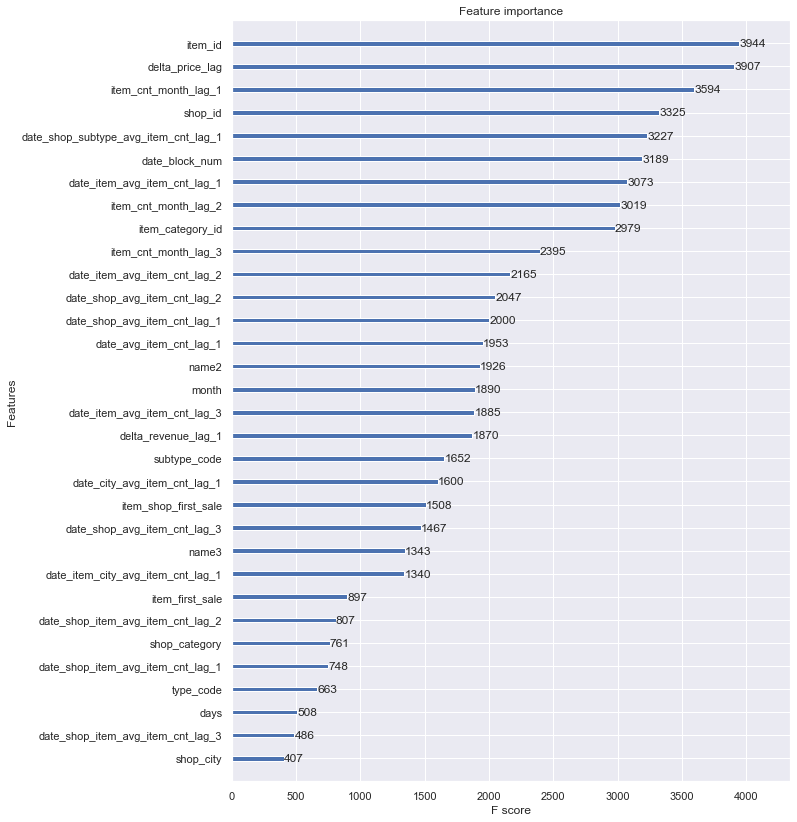

In [10]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

xgb_submission_0.890757_0.1_20.csv : window/0.88906